# Кластеризация ЕГЭ (4 если сделаны все задачи)

Рядом лежат данные с координатами точек. Везде используется Евклидово расстояние. Кластером считается набор не менее чем из 30 точек связанных друг с другом. Аномалия это точка находящаяся на расстоянии более 1 от любого кластера.

* Постройте Распределение точек
* Напишите руками DBSCAN и обработайте им все файлы
* Файл 0.xls также решите руками
* Постройте Распределение точек, отметьте принадлежность кластеров цветами
* Отметьте Аномалии отдельным цветом
* Найдите среди в каждом кластере точку расстояние от которой до всех остальных минимально
* Выведите два числа - Среднее абсцисс и ординат центроидов кластеров * 100000

Среднее центроидов кластеров * 10000: 4439.914039, -5124.401090


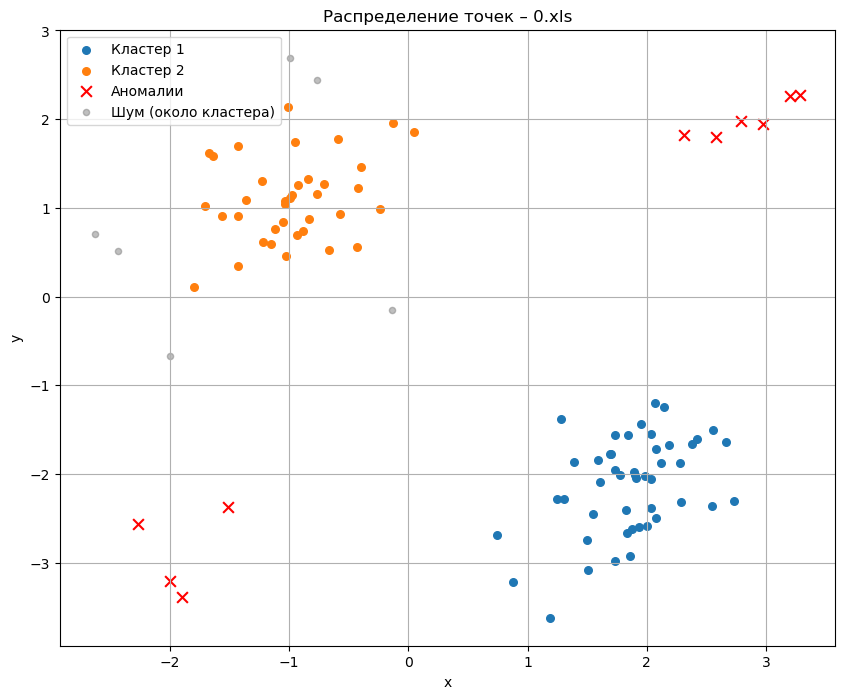

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

def euclidean(a, b):
    return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

def region_query(i, eps, X):
    neighbors = []
    for j in range(len(X)):
        if euclidean(X[i], X[j]) <= eps:
            neighbors.append(j)
    return neighbors

def expand_cluster(i, neighbors, cluster_id, eps, min_samples, X, visited, labels):
    labels[i] = cluster_id
    k = 0
    while k < len(neighbors):
        j = neighbors[k]
        if not visited[j]:
            visited[j] = True
            new_neighbors = region_query(j, eps, X)
            if len(new_neighbors) >= min_samples:
                neighbors.extend(new_neighbors)
        if labels[j] == -1:
            labels[j] = cluster_id
        k += 1

def dbscan(X, eps, min_samples):
    n = len(X)
    labels = [-1] * n
    visited = [False] * n
    cluster_id = 0
    for i in range(n):
        if visited[i]:
            continue
        visited[i] = True
        neighbors = region_query(i, eps, X)
        if len(neighbors) < min_samples:
            labels[i] = -1
        else:
            cluster_id += 1
            expand_cluster(i, neighbors, cluster_id, eps, min_samples, X, visited, labels)
    return np.array(labels)

def process_file(filename, eps=1.0, min_samples=30):
    df = pd.read_excel(filename, header=0)
    points = df.iloc[:, :2].values.astype(float)
    X = points[:, 0]
    Y = points[:, 1]

    labels = dbscan(points, eps, min_samples)

    cluster_counts = Counter(labels[labels != -1])
    valid_clusters = {cid for cid, cnt in cluster_counts.items() if cnt >= min_samples}

    filtered_labels = labels.copy()
    for i, lbl in enumerate(filtered_labels):
        if lbl != -1 and lbl not in valid_clusters:
            filtered_labels[i] = -1

    cluster_points = points[filtered_labels != -1]
    is_anomaly = np.full(len(points), False)
    if len(cluster_points) > 0:
        for i in range(len(points)):
            if filtered_labels[i] == -1:
                min_dist = np.min([euclidean(points[i], cp) for cp in cluster_points])
                if min_dist > eps:
                    is_anomaly[i] = True

    unique_labels = sorted([l for l in np.unique(filtered_labels) if l != -1])
    centroids = []

    for cid in unique_labels:
        mask = filtered_labels == cid
        cluster_pts = points[mask]
        best_idx = None
        best_sum = np.inf
        for idx, pt in enumerate(cluster_pts):
            total_dist = np.sum([euclidean(pt, other) for other in cluster_pts])
            if total_dist < best_sum:
                best_sum = total_dist
                best_idx = idx
        centroids.append(cluster_pts.mean(axis=0))

    if centroids:
        avg_centroid = np.mean(centroids, axis=0)
        avg_centroid_x10000 = avg_centroid[0] * 10000
        avg_centroid_y10000 = avg_centroid[1] * 10000
        print(f"Среднее центроидов кластеров * 10000: {avg_centroid_x10000:.6f}, {avg_centroid_y10000:.6f}")
    else:
        print("Кластеры не найдены.")
        avg_centroid_x10000 = avg_centroid_y10000 = 0

    plt.figure(figsize=(10, 8))
    colors = plt.cm.tab10.colors

    for i, cid in enumerate(unique_labels):
        mask = filtered_labels == cid
        plt.scatter(X[mask], Y[mask], c=[colors[i % len(colors)]], label=f'Кластер {cid}', s=30)

    plt.scatter(X[is_anomaly], Y[is_anomaly], c='red', marker='x', s=60, label='Аномалии')

    noise_mask = (filtered_labels == -1) & (~is_anomaly)
    plt.scatter(X[noise_mask], Y[noise_mask], c='gray', alpha=0.5, s=20, label='Шум (около кластера)')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Распределение точек – {os.path.basename(filename)}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{os.path.splitext(filename)[0]}_clusters.png", dpi=150)
    plt.show()

    return avg_centroid_x10000, avg_centroid_y10000

def main():
    xls_files = glob.glob("0.xls")
    for fname in xls_files:
        process_file(fname)

if __name__ == "__main__":
    main()

# Кластеризация (1 за каждый алгоритм на всех данных)

На предложенных распределениях данных проверьте предложенные алгоритмы. Постройте графики кластеризации для каждой пары алгоритм-данные, разные кластеры покрасьте разным цветом. Воспользуйтесь sklearn реализациями. Параметры кластеризации для разных алгоритмов подберите такие, чтобы алгоритмы можно было сравнивать (по возможности одинаковое количество кластеров и т.д.)

In [10]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.cluster import (
    KMeans,
    DBSCAN,
    MeanShift,
    estimate_bandwidth,
    SpectralClustering,
    AgglomerativeClustering,
    OPTICS,
)
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

warnings.filterwarnings("ignore")

In [11]:
np.random.seed(0)

# ============
# Generate datasets
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 10,
    "n_clusters": 3,
    "min_samples": 20,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 20,
            "xi": 0.25,
        },
    ),
    (noisy_moons, {"damping": 0.75, "preference": -220, "n_clusters": 2}),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 5,
            "xi": 0.035,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 20,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {}),
    (no_structure, {}),
]


# ============
# Define clustering algorithms
# ============
clustering_algorithms = [
    (
        "KMeans",
        lambda params: KMeans(n_clusters=params["n_clusters"], n_init="auto", random_state=0),
    ),
    (
        "DBSCAN",
        lambda params: DBSCAN(eps=params["eps"], min_samples=params["min_samples"]),
    ),
    (
        "MeanShift",
        lambda params: MeanShift(bandwidth=None, bin_seeding=True),  # bandwidth estimated later
    ),
    (
        "Spectral\nClustering",
        lambda params: SpectralClustering(
            n_clusters=params["n_clusters"],
            eigen_solver="arpack",
            affinity="nearest_neighbors",
            n_neighbors=params["n_neighbors"],
            random_state=0,
        ),
    ),
    (
        "Ward",
        lambda params: AgglomerativeClustering(
            n_clusters=params["n_clusters"], linkage="ward", connectivity=None
        ),
    ),
    (
        "Agglomerative\nClustering",
        lambda params: AgglomerativeClustering(
            n_clusters=params["n_clusters"], linkage="average", connectivity=None
        ),
    ),
    (
        "OPTICS",
        lambda params: OPTICS(
            min_samples=params["min_samples"],
            xi=params["xi"],
            min_cluster_size=params["min_cluster_size"],
        ),
    ),
    (
        "Gaussian\nMixture",
        lambda params: GaussianMixture(
            n_components=params["n_clusters"], covariance_type="full", random_state=0
        ),
    ),
]

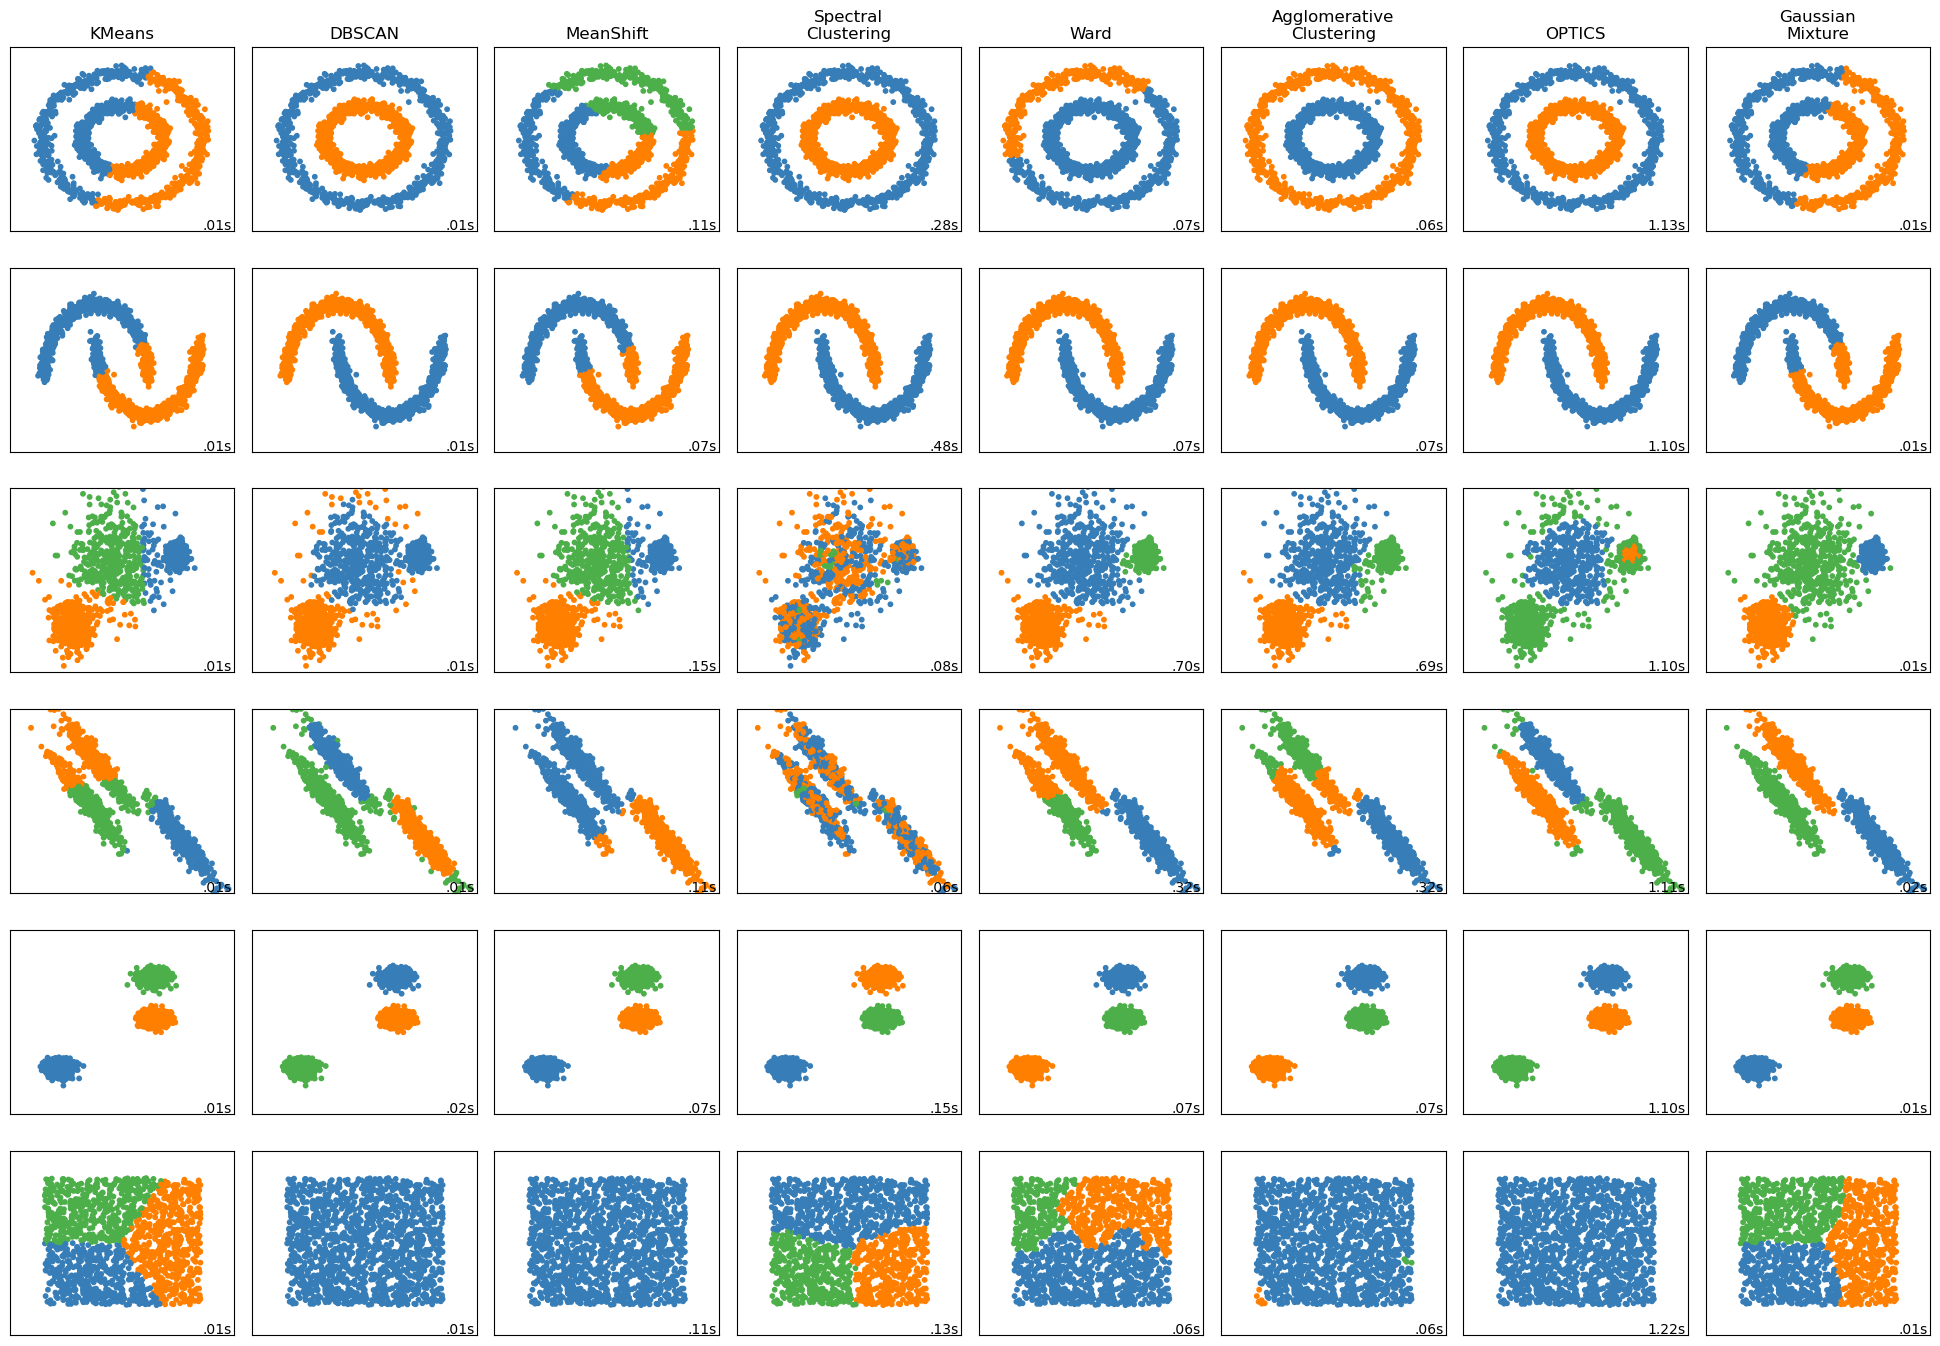

In [12]:

# ============
# Plotting
# ============
plt.figure(figsize=(len(clustering_algorithms) * 2 + 4, len(datasets) * 2 + 2))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.02, top=0.94, wspace=0.08, hspace=0.2
)

plot_num = 1

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    X, y = dataset
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for MeanShift
    bandwidth = estimate_bandwidth(X, quantile=algo_params.get("quantile", default_base["quantile"]))

    # connectivity for Ward & average linkage
    connectivity = kneighbors_graph(
        X,
        n_neighbors=algo_params.get("n_neighbors", default_base["n_neighbors"]),
        include_self=False,
    )
    connectivity = 0.5 * (connectivity + connectivity.T)

    for name, algorithm_factory in clustering_algorithms:
        # special handling for connectivity-dependent algorithms
        if name in ("Ward", "Agglomerative\nClustering"):
            params = algo_params.copy()
            params["connectivity"] = connectivity
            algorithm = AgglomerativeClustering(
                n_clusters=params.get("n_clusters", default_base["n_clusters"]),
                linkage=name.lower() if name == "Ward" else "average",
                connectivity=params["connectivity"],
            )
        elif name == "MeanShift":
            algorithm = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        elif name == "Spectral\nClustering":
            algorithm = SpectralClustering(
                n_clusters=algo_params.get("n_clusters", default_base["n_clusters"]),
                eigen_solver="arpack",
                affinity="nearest_neighbors",
                n_neighbors=algo_params.get("n_neighbors", default_base["n_neighbors"]),
                random_state=0,
            )
        else:
            params = {**default_base, **algo_params}
            algorithm = algorithm_factory(params)

        t0 = time.time()
        # fit and predict
        if hasattr(algorithm, "fit_predict"):
            y_pred = algorithm.fit_predict(X)
        elif hasattr(algorithm, "fit"):
            algorithm.fit(X)
            if hasattr(algorithm, "predict"):
                y_pred = algorithm.predict(X)
            elif hasattr(algorithm, "labels_"):
                y_pred = algorithm.labels_
            else:
                y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit_predict(X)
        t1 = time.time()

        # plot
        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=12)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # black for noise (if any)
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred] if max(y_pred) >= 0 else "k")

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=10,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()